In [1]:
import re
import sqlite3
import time
import pycountry
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer 
import warnings
4
#não mostrar os erros
warnings.filterwarnings("ignore")

#tema branco0174
sns.set_theme(style="whitegrid")


In [2]:
#mostrar tempo de execução
%time

#Gerar arquivo
!imdb-sqlite

Wall time: 0 ns


'imdb-sqlite' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [3]:
#Database connect
conn = sqlite3.connect('imdb.db')

#extrair as tabelas 
tabelas = pd.read_sql_query("SELECT NAME  as 'Table_Name' FROM sqlite_master WHERE type = 'table'",conn)

# ver as primerias linhas da tabela
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [4]:
#convertendo para manipular como lista
tabelas = tabelas["Table_Name"].values.tolist()

In [5]:
#Selecionar a consulta -> Informações da tabela e dps formatar

for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("_"*100)
    print("\n")

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


____________________________________________________________________________________________________


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


____________________________________________________________________________________________________




# 1 - Categorias mais comuns no IMDB

    Quais as categorias de filmes mais comuns?

In [6]:
# Criar consulta SQL 
# seleciona a categoria (contando-as), agrupando pela prórpia categooria
# Vindo da tabela titulos
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [7]:
#Executando consulta
resultado1 =pd.read_sql_query(consulta1,conn)
#Mostrando resultado
display(resultado1)

,type,COUNT
0,movie,582549
1,radioEpisode,1
2,radioSeries,1
3,short,821027
4,tvEpisode,5919232
5,tvMiniSeries,38326
6,tvMovie,132129
7,tvSeries,210861
8,tvShort,10143
9,tvSpecial,33359


In [8]:
#colocando em percentual -> Total / soma 
resultado1['Percentual'] = (resultado1['COUNT']/resultado1['COUNT'].sum()*100)

#mostrando
display(resultado1)

,type,COUNT,Percentual
0,movie,582549,7.200456
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,821027,10.148106
4,tvEpisode,5919232,73.163235
5,tvMiniSeries,38326,0.473719
6,tvMovie,132129,1.633149
7,tvSeries,210861,2.606296
8,tvShort,10143,0.125370
9,tvSpecial,33359,0.412326


In [9]:
# Colocando apenas 4 categororias => Gráfico
# 3> && 1 c/ resto

# dicionário vazio
others={}

#filtra percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['Percentual']<5]['COUNT'].sum()

#gravando o percentual
others['Percentual'] = resultado1[resultado1['Percentual']<5]['COUNT'].sum()

#Ajustando nome
others['type'] = 'others'

#olhando
others

{'COUNT': 767638, 'Percentual': 767638, 'type': 'others'}

In [10]:
#filtrando resultados
resultado1 = resultado1[resultado1['Percentual']>5]

#Append com dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

#ordenar o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending=False)

resultado1.head()

,type,COUNT,Percentual
2,tvEpisode,5919232,73.163235
1,short,821027,10.148106
3,others,767638,767638.000000
0,movie,582549,7.200456


In [11]:
# Ajustando as labels
labels = [str(resultado1['type'][i]) + ' ' + '[' + str(round(resultado1['Percentual'][i],2)) + '%' + ']' for i in resultado1.index]

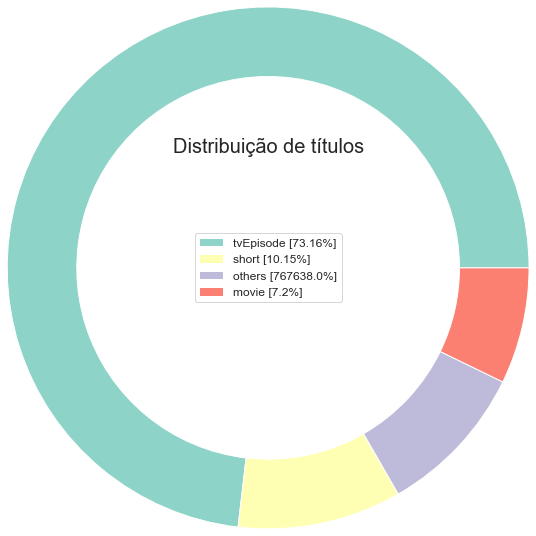

In [12]:
# PLOT

#Mapa de cores 
cs = cm.Set3(np.arange(100))

# Cria a figura 
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance=1, radius=3, colors = cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels,loc='center', prop= {'size':12})
plt.title("Distribuição de títulos", loc="Center", fontdict = {'fontsize':20, 'fontweight':20})

plt.show()

# 2 - Número de  títulos por gêneros

Calculando o número de filmes por gêneros 

In [13]:
# Criando a consulta SQL
# selecionando a tabela gêneros, contando os movies, agrupando pelo gênero 
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

#vendo
display(resultado2)

,genres,COUNT(*)
0,Action,13257
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1438,"Thriller,Western",37
1439,War,1249
1440,"War,Western",9
1441,Western,4054


In [14]:
#convertendo as strings para minúsculo
consulta2 = resultado2['genres'].str.lower().values

In [15]:
#removendo valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [16]:
# Criar um vetor com regex para filtrar strings

#declarando regex
padrao = '(?u)\\b[\\w]+\\b'

# Cria uma matriz de token -> Buscar um padrão 
vetor = CountVectorizer(token_pattern= padrao, analyzer='word').fit(temp)

In [17]:
#aplicando ao  dataset a detecção de padrão
bag_generos = vetor.transform(temp)

type(bag_generos)

scipy.sparse.csr.csr_matrix

In [18]:
#retornar gêneros únicos
generos_unicos = vetor.get_feature_names()

In [19]:
# criando dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

#visualizando
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1442
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1443 non-null   int64
 1   adult        1443 non-null   int64
 2   adventure    1443 non-null   int64
 3   animation    1443 non-null   int64
 4   biography    1443 non-null   int64
 5   comedy       1443 non-null   int64
 6   crime        1443 non-null   int64
 7   documentary  1443 non-null   int64
 8   drama        1443 non-null   int64
 9   family       1443 non-null   int64
 10  fantasy      1443 non-null   int64
 11  fi           1443 non-null   int64
 12  film         1443 non-null   int64
 13  game         1443 non-null   int64
 14  history      1443 non-null   int64
 15  horror       1443 non-null   int64
 16  music        1443 non-null   int64
 17  musical      1443 non-null   int64
 18  mystery      1443 non-null   int64
 19  n            1443 non-null   int64
 20  news    

In [20]:
#drop column n
generos = generos.drop(columns='n', axis=0)

In [21]:
generos_percentual = 100*pd.Series(generos.sum()).sort_values(ascending=False)/generos.shape[0]

In [22]:
generos_percentual

drama          18.503119
comedy         16.770617
documentary    16.008316
adventure      14.899515
action         14.622315
romance        13.444213
crime          13.028413
mystery        12.543313
thriller       12.474012
fantasy        12.266112
horror         11.850312
history        11.781012
music          11.088011
family         11.088011
animation      11.088011
biography      10.672211
sci            10.672211
fi             10.672211
musical        10.395010
war             8.870409
western         8.870409
sport           8.177408
adult           6.098406
news            3.603604
reality         2.910603
tv              2.910603
film            2.356202
noir            2.356202
short           1.801802
show            1.386001
talk            0.970201
game            0.415800
dtype: float64

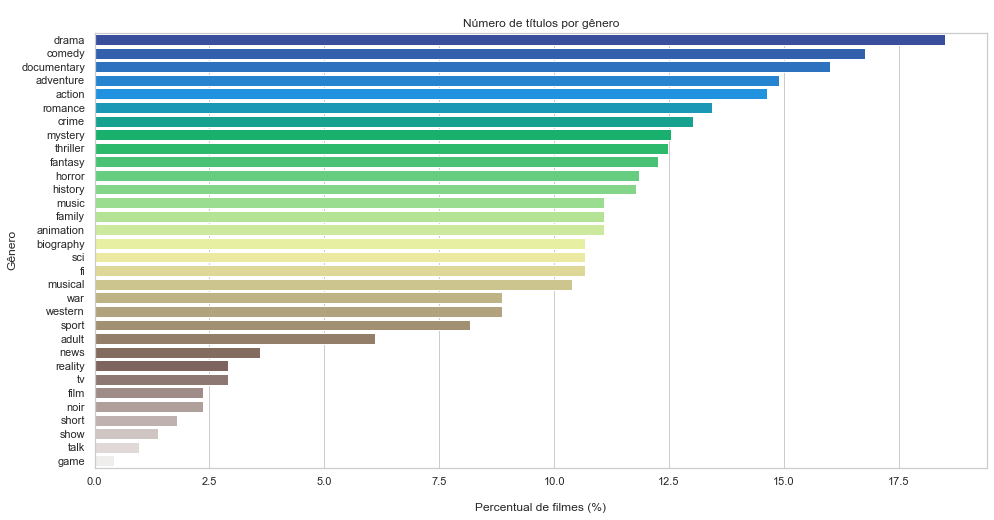

In [23]:
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient="h", palette="terrain")

plt.ylabel('Gênero')
plt.xlabel("\nPercentual de filmes (%)")
plt.title("\nNúmero de títulos por gênero")

plt.show()

# 3 - Mediana de filmes por gênero

Mediana de avaliação

A mediana é usada principalmente quando não há a avaliação de valores extremos (outliers)

In [24]:
#consulta sql 
consulta3 = ''' 
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 and type = 'movie'
            
            '''
#resultado
resultado3 =pd.read_sql_query(consulta3,conn)

#visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
265905,3.6,"Action,Adventure,Thriller"
265906,5.8,Thriller
265907,6.3,"Adventure,Drama,History"
265908,3.8,"Adventure,History,War"


In [25]:
# função para retornar gêneros
def retorna_genero(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    return generos_unicos

In [26]:
#aplicando a função
generos_unicos = retorna_genero(resultado3)

#visualizar
display(generos_unicos)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'n',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

# Mediana de Avaliação - Ano de Estréia

In [27]:
# Consulta SQL 
consulta4 = ''' 
            SELECT rating AS rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <=2022 AND type = 'movie'
            order by premiered
            ''' 

In [28]:
resultado4 = pd.read_sql_query(consulta4, conn)

display(resultado4)

,rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
265905,6.6,2021
265906,4.8,2021
265907,8.3,2021
265908,6.0,2021


In [29]:
#Calculando a mediana ao longo do tempo
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered']==year]['rating']))

type(ratings)

list

In [30]:
# lista de anos

anos = list(set(resultado4['premiered']))

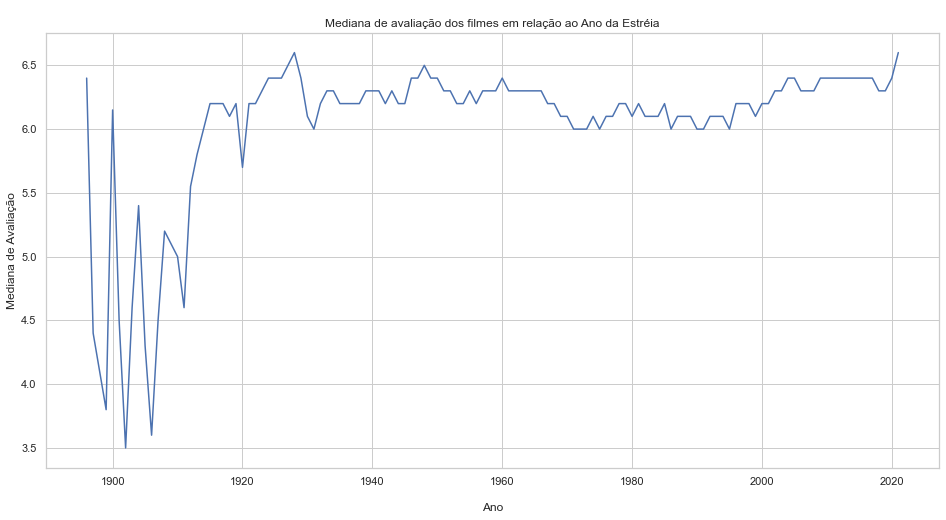

In [31]:
plt.figure(figsize=(16,8))
plt.plot(anos,ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de avaliação dos filmes em relação ao Ano da Estréia')
plt.show()

## 5 - Número de filmes avaliados por gênero em relação ao ano de estréia


In [32]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles'''

resultado5 = pd.read_sql_query(consulta5, conn)

display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8090441,"Action,Drama,Family"
8090442,"Action,Drama,Family"
8090443,"Action,Drama,Family"
8090444,Short


In [33]:
generos_unicos = retorna_genero(resultado5)

In [34]:
#fazendo a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [35]:
# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

# 6 - Filme com maior tempo de execução

Percentis e filme mais longo da história

In [36]:
#Consulta SQL 
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

In [37]:
#resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [38]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
366716,123
366717,57
366718,100
366719,116


In [39]:
#loop para calcular os percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val),2)
    print('{} percentil da duração (runtime) é: {}'.format(val,perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

# 7 - Relação entre Duração e Gênero

 A relação entre o gênero e a duração 
 

In [45]:
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE type = 'movie' AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''
resultado7 = pd.read_sql_query(consulta7, conn)

resultado7

,Runtime,genres
0,99.406224,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1356,93.928571,"Thriller,Western"
1357,93.466321,War
1358,98.000000,"War,Western"
1359,72.065357,Western


In [49]:
generos_unicos = retorna_genero(resultado7)

generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'n',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [53]:
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta,conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [56]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

df_genero_runtime = df_genero_runtime.drop(index=18)
df_genero_runtime = df_genero_runtime.sort_values(by='runtime', ascending = False)

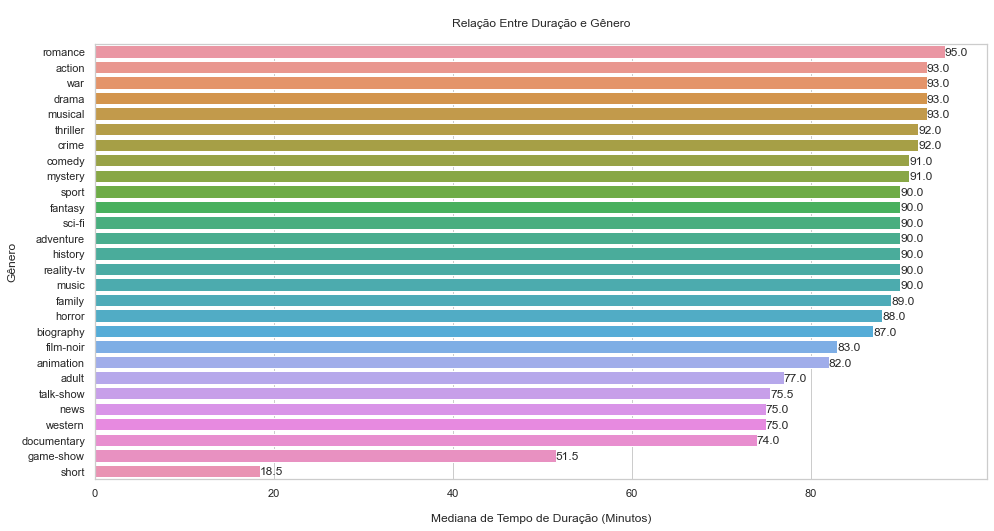

In [57]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()